In [46]:
import matplotlib.pyplot as plt
import psycopg2
import time

In [47]:
# Параметры подключения к базам данных
PRIMARY_DB = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5433'
}

STANDBY_DB = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5434'
}

In [48]:
# Логгер количества записей
class Logger:
    def __init__(self):
        self.timestamps = []
        self.primary_record_count = []
        self.standby_record_count = []

    # получить количество записей в БД
    def get_db_record_count(self, db_config):
        try:
            with psycopg2.connect(**db_config) as conn:
                with conn.cursor() as cur:
                    cur.execute("SELECT COUNT(*) FROM data_table")
                    count = cur.fetchone()[0]
            return count
        except Exception as e:
            return -1
    
    # Сохранить информацию о количестве записей
    def log(self):
        self.timestamps.append(time.time())
        self.primary_record_count.append(self.get_db_record_count(PRIMARY_DB))
        self.standby_record_count.append(self.get_db_record_count(STANDBY_DB))

    # Построить график количества записей от времени
    def plot(self):
        times = [t - self.timestamps[0] for t in self.timestamps]
        print(f'количество записей в primary {max(self.primary_record_count)}/{len(times)}')
        print(f'количество записей в standby {max(self.standby_record_count)}/{len(times)}')
        plt.plot(times, self.primary_record_count, label='primary', marker='o')
        plt.plot(times, self.standby_record_count, label='standby')
        plt.legend()
        plt.xlabel("Время")
        plt.ylabel("Количество записей в БД") 
        plt.show()

In [53]:
# reverse proxy для переключения с PRIMARY_DB на STANDBY_DB
class Proxy:
    def __init__(self):
        self.is_primary_alive = True
        self.primary_record_count = []
        self.standby_record_count = []

    # Выполнить promote в БД
    def promote(self, db_config):
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("SELECT pg_promote()")
                conn.commit()

    # Поместить данные в БД
    def raw_insert(self, db_config, value):
        try:
            with psycopg2.connect(**db_config) as conn:
                with conn.cursor() as cur:
                    cur.execute("INSERT INTO data_table (name) VALUES (%s)", (value,))
                    conn.commit()
            return True
        except Exception as e:
            print(f"Ошибка при вставке данных: {e}")  # Логируем ошибку
            return False
        
    # Поместить данные в "живую" БД
    def insert(self, value):
        if self.is_primary_alive:
            if not self.raw_insert(PRIMARY_DB, value):
                self.is_primary_alive = False
                # self.promote(STANDBY_DB)       
        if not self.is_primary_alive:
            self.raw_insert(STANDBY_DB, value)

In [54]:
# Получение данных которые наобходимо записать в БД
def get_value() -> str:
    return "test string"

# Создать таблицу с тестовыми данными
def init_table(db_config):
    try:
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("CREATE TABLE data_table (id SERIAL, name TEXT);")
    except Exception as e:
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cur:
                cur.execute("DELETE FROM data_table;")

Ошибка при вставке данных: connection to server at "localhost" (127.0.0.1), port 5433 failed: FATAL:  the database system is shutting down

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вставке данных: cannot execute INSERT in a read-only transaction

Ошибка при вс

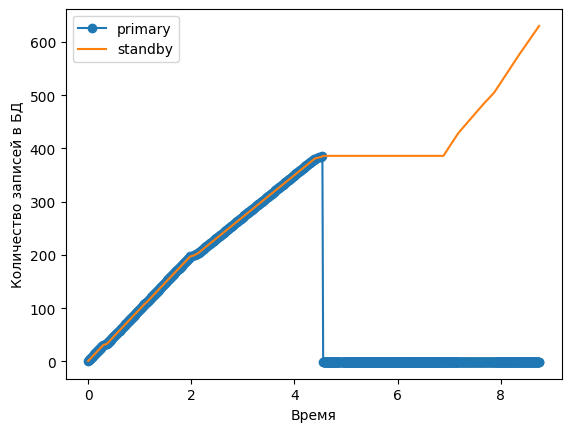

In [55]:
proxy = Proxy()
logger = Logger()
init_table(PRIMARY_DB)

for _ in range(1000):
    proxy.insert(get_value())
    logger.log()
    
logger.plot()